# Introduction to the Jax backend

ReservoirPy v0.4.1 introduces the Jax backend, an implementation of the classical ReservoirPy nodes using the Jax library instead of NumPy. Jax offers several machine learning features, such as differentiation, and allows for Python programs to be executed either on the CPU or on the GPU through function computation, which allows for a significant speed improvement on complex tasks.

An overview of the jax library can be found at https://docs.jax.dev/en/latest/.

In [ ]:
%pip install "reservoirpy[jax]"

In [2]:
# Imports
import time
import tqdm

import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

rng = np.random.default_rng(seed=260_418)

In [ ]:
# # Depending on your machine, it is sometimes better to only use the CPU
# jax.config.update('jax_platform_name', 'cpu')
# print(jax.numpy.ones(3).device) # TFRT_CPU_0

TFRT_CPU_0


### Importing Jax nodes

Jax implementations of classical ReservoirPy classes and methods are mirrored from `reservoirpy` to `reservoirpy.jax`:

In [4]:
import reservoirpy as rpy
import reservoirpy.jax as rjx

# Data definition
X = rng.uniform(size=(1200, 2))
X_train, X_test = X[:1000], X[1000:]
Y = X @ rng.uniform(size=(2, 1)) + rng.normal(scale=0.1, size=(1200, 1))  # noisy linear combination of X
Y_train, Y_test = Y[:1000], Y[1000:]

In [5]:
numpy_model = rpy.nodes.Reservoir(100, lr=0.7) >> rjx.nodes.Ridge(1e-2)
y_pred_np = numpy_model.fit(X_train, Y_train, warmup=10).run(X_test)

jax_model = rjx.nodes.Reservoir(100, lr=0.7) >> rjx.nodes.Ridge(1e-2)
y_pred_jax = jax_model.fit(X_train, Y_train, warmup=10).run(X_test)

Or, with the `ESN` model:

In [6]:
numpy_model = rpy.ESN(units=100, lr=0.7, ridge=1e-2)
jax_model = rjx.ESN(units=100, lr=0.7, ridge=1e-2)

### Performances

Thanks to Jax code compilation and optimization, and its ability to run on GPUs, you can expect a significant performance boost on large models and with large datasets, making it ideal of resource intensive tasks.

Here, we are illustrating this on reservoirs of various size, processing a timeseries of 100.000 timesteps, both using numpy and jax.

10 neurons:
	NumPy time: 1.05s	Jax time:   2.749s
21 neurons:
	NumPy time: 1.049s	Jax time:   0.1923s
46 neurons:
	NumPy time: 1.124s	Jax time:   4.093s
100 neurons:
	NumPy time: 1.226s	Jax time:   0.08505s
215 neurons:
	NumPy time: 1.674s	Jax time:   1.11s
464 neurons:
	NumPy time: 3.183s	Jax time:   0.3571s
1000 neurons:
	NumPy time: 9.787s	Jax time:   0.3795s
2154 neurons:
	NumPy time: 40.04s	Jax time:   12.16s
4641 neurons:
	NumPy time: 217.9s	Jax time:   22.49s
10000 neurons:
	NumPy time: 1.09e+03s	Jax time:   59.42s
10it [24:30, 147.06s/it]


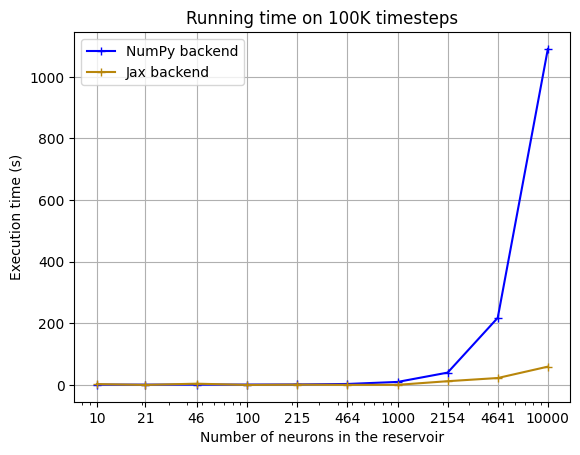

In [11]:
N_NEURONS_LIST = np.logspace(1, 4, 10, dtype=np.int64)
X = rng.uniform(size=(100_000, 2))

numpy_scores = np.zeros(10)
jax_scores = np.zeros(10)

for i, n_neuron in tqdm.tqdm(enumerate(N_NEURONS_LIST)):
    print(f"{n_neuron} neurons:")
    reservoir = rpy.nodes.Reservoir(n_neuron)
    start = time.time()
    reservoir.run(X)
    stop = time.time()
    numpy_scores[i] = stop - start
    print(f"\tNumPy time: {numpy_scores[i]:.3}s", end="")

    reservoir = rjx.nodes.Reservoir(n_neuron)
    start = time.time()
    reservoir.run(X)
    stop = time.time()
    jax_scores[i] = stop - start
    print(f"\tJax time:   {jax_scores[i]:.3}s")

plt.figure()
plt.title("Running time on 100K timesteps")
plt.plot(N_NEURONS_LIST, numpy_scores, "-+", color="blue", label="NumPy backend")
plt.plot(N_NEURONS_LIST, jax_scores, "-+", color="darkgoldenrod", label="Jax backend")
plt.xscale("log")
plt.xlabel("Number of neurons in the reservoir")
plt.xticks(N_NEURONS_LIST, N_NEURONS_LIST)
plt.ylabel("Execution time (s)")
plt.legend()
plt.grid()
plt.show()

We can see a major improvement in execution time between the numpy and the jax models. This will be dependent on your task, model, and of course your hardware.

### Differentiation of ReservoirPy nodes and models

With the Jax backend of ReservoirPy, you can now compute the gradient of any pure-jax nodes or models.

#### Jacobian of a Node

Let's compute the jacobian of the edge of stability reservoir:

In [28]:
# create a simple ES2N jax node
node = rjx.nodes.ES2N(5, proximity=0.7, sr=0.3, input_connectivity=0.5)
# warm it up
X = rng.uniform(0, 1, (200, 2))
_ = node.run(X)

Every node have their `_step` method. This is a pure function, that takes two arguments:

0. The previous node state: this represents the state of the node as a dict of 1-D arrays. Its `"out"` key holds the previous output of the node.

1. The input. This is a 1-D array (a timestep).

This method returns a dict that represents the new state of the node. The `"out"` key holds the output of the node.

Knowing this, we can now compute the gradient out of the input or the previous node state.

In [33]:
# observation point
x = rng.uniform(0, 1, (2,))

# Jacobian of ES2N with respect to the ES2N neurons state
jac_from_state = jax.jacobian(node._step, argnums=0)(node.state, x)["out"]["out"]

# Jacobian of ES2N with respect to the input
jac_from_input = jax.jacobian(node._step, argnums=1)(node.state, x)["out"]


print("Jacobian from the previous node state")
print(jac_from_state, jac_from_state.shape)
print()
print("Jacobian from the input")
print(jac_from_input, jac_from_input.shape)

Jacobian from the previous node state
[[-0.0501061  -0.09248547  0.26618147  0.01790377  0.08810618]
 [ 0.20109053 -0.07552128 -0.04068021 -0.10149956  0.17861159]
 [-0.24658939  0.17018531 -0.03242167  0.09391422  0.2106711 ]
 [ 0.016499   -0.1676245  -0.07927462  0.34407818  0.02540072]
 [-0.19999039 -0.13668197 -0.10078154 -0.12592565  0.07285397]] (5, 5)

Jacobian from the input
[[ 0.69997984  0.        ]
 [ 0.5073371   0.5073371 ]
 [ 0.          0.        ]
 [ 0.         -0.36732516]
 [-0.69997984  0.        ]] (5, 2)


##### Jacobian of a Model

The jacobian of a Model follows the same logic, though it is a bit more complex since we are handling more states and outputs at the same time.

Let's create a simple echo state network.

In [35]:
reservoir = rjx.nodes.Reservoir(10)
readout = rjx.nodes.Ridge(1e-3)
model = reservoir >> readout

Y = rng.uniform(0, 1, (200, 1))
model.fit(X, Y)

Model(Reservoir(units:10, input_dim:2), Ridge(ridge:10, input_dim:10, output_dim:1))

Model also have their `_step` purely-functional method. It takes two arguments:

0. The previous model state: this is a tuple where the first element is a mapping of the feedback buffers (we don't have any here), and a mapping of the node states.

1. The input. This is a mapping of 1-D arrays (timesteps).

This method returns a dict that represents the new state of the model as described above.

In [40]:
# Illustration of the _step method
new_buffers, new_states = model._step(
    (model.feedback_buffers, {n: n.state for n in model.nodes}),
    {reservoir: x}
)
new_states

{Reservoir(units:10, input_dim:2): {'out': Array([ 0.        ,  0.        ,  0.        ,  0.00536855, -0.00536855,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],      dtype=float32)},
 Ridge(ridge:10, input_dim:10, output_dim:1): {'out': Array([0.45553914], dtype=float32)}}

Now that we have this in mind, we can compute its jacobian!

In [60]:
# Jacobian of ESN model with respect to the input
jac_from_input = jax.jacobian(model._step, argnums=1)(
    (model.feedback_buffers, {n: n.state for n in model.nodes}),
    {reservoir: x}
)

# output of the readout with respect to the input
jac_from_input[1][readout]["out"][reservoir]

Array([[0.09668329, 0.        ]], dtype=float32)